In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [2]:
import os
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as dlbq

In [3]:
tf.test.is_built_with_cuda()

False

In [4]:
tf.logging.set_verbosity(tf.logging.INFO)

---
##### From Jupyter notebook to python package
From exploration to production.

This little tool dumps a given function to a file with the same name in a certain package

In [5]:
PACKAGE="./train"
from tools import make_src_dumper
write_py = make_src_dumper(PACKAGE)

---
# Prediction 


#### Signature data for testing

First, let's get some test data. Now we need signature data, and that's what we have in Bigquery. Remember? 

In [6]:
from train.model_config import SIGNATURE_FLOAT_COLUMNS
from train.model_config import SIGNATURE_INT_COLUMNS
from train.model_config import SIGNATURE_STR_COLUMNS
from signature_queries import sample_query

SIGNATURE_COLUMNS = SIGNATURE_FLOAT_COLUMNS+SIGNATURE_INT_COLUMNS+SIGNATURE_STR_COLUMNS
signature_query=sample_query(SIGNATURE_COLUMNS, total=10000)
print(signature_query)
sample = dlbq.Query(signature_query).execute().result().to_dataframe()
print('Only {} examples. Showing first three:'.format(len(sample)))
sample[:3]


    SELECT
        DEP_LAT, DEP_LON, DEP_DELAY, MEAN_TEMP_DEP, MEAN_VIS_DEP, WND_SPD_DEP, ARR_LAT, ARR_LON, ARR_DELAY, MEAN_TEMP_ARR, MEAN_VIS_ARR, WND_SPD_ARR, DEP_DOW, DEP_T, ARR, AIRLINE
    FROM 
        `going-tfx.examples.ATL_JUNE_SIGNATURE` 
    where
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT(DATE,AIRLINE,ARR)
        )) + DEP_T, 10000) >= 0 
    and
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT( DATE, AIRLINE, ARR)
        )) + DEP_T, 10000) < 1 
    
Only 37 examples. Showing first three:


,DEP_LAT,DEP_LON,DEP_DELAY,MEAN_TEMP_DEP,MEAN_VIS_DEP,WND_SPD_DEP,ARR_LAT,ARR_LON,ARR_DELAY,MEAN_TEMP_ARR,MEAN_VIS_ARR,WND_SPD_ARR,DEP_DOW,DEP_T,ARR,AIRLINE
0,33.63,-84.42,1.0,83.9,10.0,6.2,40.77,-73.87,-2.0,80.7,8.9,5.7,1,2140,LGA,DL
1,33.63,-84.42,-3.0,71.0,9.9,6.0,37.13,-76.49,1.0,65.5,9.9,6.5,1,1130,PHF,FL
2,33.63,-84.42,-7.0,77.9,9.7,5.4,32.89,-80.04,-6.0,84.1,8.4,8.6,1,1505,CHS,DL


In [7]:
import json
samplefile='/tmp/test.json'
a_record = sample.to_dict(orient='records')[0]
a_record.pop('ARR_DELAY')
with open(samplefile, 'w') as f:
    f.write(json.dumps(a_record))
!cat $samplefile

{"WND_SPD_DEP": 6.2, "DEP_DELAY": 1.0, "ARR_LAT": 40.77, "WND_SPD_ARR": 5.7, "MEAN_VIS_DEP": 10.0, "DEP_T": 2140, "MEAN_TEMP_ARR": 80.7, "DEP_LON": -84.42, "DEP_DOW": 1, "MEAN_VIS_ARR": 8.9, "ARR": "LGA", "AIRLINE": "DL", "MEAN_TEMP_DEP": 83.9, "DEP_LAT": 33.63, "ARR_LON": -73.87}

---
#### Local prediction with gcloud ml-engine

In [8]:
DATASET='samples'
model_dir='gs://going-tfx/%s/model' % DATASET
all_versions = !gsutil ls $model_dir/export/exporter
all_versions[1:]

['gs://going-tfx/samples/model/export/exporter/1542975653/',
 'gs://going-tfx/samples/model/export/exporter/1542975707/',
 'gs://going-tfx/samples/model/export/exporter/1542975746/']

Choose your version from the above

In [9]:
latest_model=!gsutil ls gs://going-tfx/$DATASET/model/export/exporter | sort | tail -1
latest_model = latest_model[0]
latest_model

'gs://going-tfx/samples/model/export/exporter/1542975746/'

In [10]:
!gcloud ml-engine local predict \
  --model-dir=$latest_model \
  --json-instances=/tmp/test.json


OUTPUT
[34.16313934326172]


In [11]:
import json
samplefile='/tmp/test.json'
records = sample.to_dict(orient='records')[:20]
with open(samplefile, 'w') as f:
    for record in records:
        record.pop('ARR_DELAY')
        f.write(json.dumps(record))
        f.write('\n')
!cat $samplefile | tail -2

{"WND_SPD_DEP": 4.8, "DEP_DELAY": 102.0, "ARR_LAT": 36.89, "WND_SPD_ARR": 7.4, "MEAN_VIS_DEP": 8.7, "DEP_T": 1728, "MEAN_TEMP_ARR": 77.6, "DEP_LON": -84.42, "DEP_DOW": 4, "MEAN_VIS_ARR": 8.9, "ARR": "ORF", "AIRLINE": "EV", "MEAN_TEMP_DEP": 78.4, "DEP_LAT": 33.63, "ARR_LON": -76.2}
{"WND_SPD_DEP": 8.4, "DEP_DELAY": -2.0, "ARR_LAT": 26.68, "WND_SPD_ARR": 4.5, "MEAN_VIS_DEP": 8.5, "DEP_T": 1605, "MEAN_TEMP_ARR": 83.1, "DEP_LON": -84.42, "DEP_DOW": 4, "MEAN_VIS_ARR": 9.3, "ARR": "PBI", "AIRLINE": "DL", "MEAN_TEMP_DEP": 74.1, "DEP_LAT": 33.63, "ARR_LON": -80.09}


---
#### Predicting from within python code

In [12]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from gs://going-tfx/samples/model/export/exporter/1542975746/variables/variables


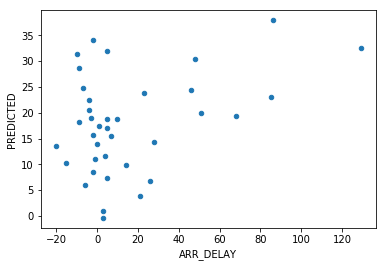

In [13]:
%matplotlib inline
compare=sample.copy()
predicted = estimator(sample.to_dict(orient='list'))
compare['PREDICTED'] = predicted['output']
compare.plot.scatter(x='ARR_DELAY', y='PREDICTED')